In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt

from bokeh.io import show, output_notebook
from bokeh.plotting import figure, from_networkx
from bokeh.models import Range1d, Plot

output_notebook()

Loading BokehJS ...

In [2]:
shawshank_coref = pd.read_csv("../../data/annotation/acl21/shawshank.coref.mapped.csv", index_col=None)
basterds_coref = pd.read_csv("../../data/annotation/acl21/basterds.coref.mapped.csv", index_col=None)
bourne_coref = pd.read_csv("../../data/annotation/acl21/bourne.coref.mapped.csv", index_col=None)

shawshank_parsed = open("../../data/annotation/acl21/shawshank.script_parsed.txt").read().strip().split("\n")
basterds_parsed = open("../../data/annotation/acl21/basterds.script_parsed.txt").read().strip().split("\n")
bourne_parsed = open("../../data/annotation/acl21/bourne.script_parsed.txt").read().strip().split("\n")


In [3]:
def create_interaction_graph(mapped_coref_df, lines):
    screenplay_tags = [line.split(":")[0] for line in lines]    
    
    mentions = []
    characters = set()
    for _, row in mapped_coref_df.iterrows():
        if pd.notna(row.pbegin_ind) and pd.notna(row.pend_ind) and row.pbegin_ind == row.pend_ind:
            mentions.append((row.entityLabel, int(row.pbegin_ind), screenplay_tags[int(row.pbegin_ind)]))
            characters.add(row.entityLabel)
    
    mention_graph = pd.DataFrame(data = np.zeros((len(characters), len(characters))), columns = characters, index = characters)
    speech_graph = pd.DataFrame(data = np.zeros((len(characters), len(characters))), columns = characters, index = characters)
    
    next_utterance_index_within_scene = np.full(len(screenplay_tags), -1)
    character_mentioned_in_utterance = pd.DataFrame(data = np.zeros((len(screenplay_tags), len(characters))), index = pd.RangeIndex(len(screenplay_tags)), columns = characters)
    character_mentioned_in_speaker = pd.DataFrame(data = np.zeros((len(screenplay_tags), len(characters))), index = pd.RangeIndex(len(screenplay_tags)), columns = characters)
    
    for character, i, tag in mentions:
        if tag == "D":
            character_mentioned_in_utterance.loc[i, character] = 1
        if tag == "C":
            character_mentioned_in_speaker.loc[i, character] = 1
    
    for i, tag in enumerate(screenplay_tags):
        if tag == "C":
            j = i + 1
            while j < len(screenplay_tags) and screenplay_tags[j] != "S":
                if screenplay_tags[j] == "C":
                    next_utterance_index_within_scene[i] = j
                    break
                j += 1
    
    for character, i, tag in mentions:
        if tag == "C":
            if i + 1 < len(screenplay_tags) and screenplay_tags[i + 1] == "D":
                mention_graph.loc[character] += character_mentioned_in_utterance.loc[i + 1]
            j = next_utterance_index_within_scene[i]
            if j != -1:
                speech_graph.loc[character] += character_mentioned_in_speaker.loc[j]
                
    return mention_graph, speech_graph

In [19]:
shawshank_mention_df, shawshank_speech_df = create_interaction_graph(shawshank_coref, shawshank_parsed)
basterds_mention_df, basterds_speech_df = create_interaction_graph(basterds_coref, basterds_parsed)
bourne_mention_df, bourne_speech_df = create_interaction_graph(bourne_coref, bourne_parsed)

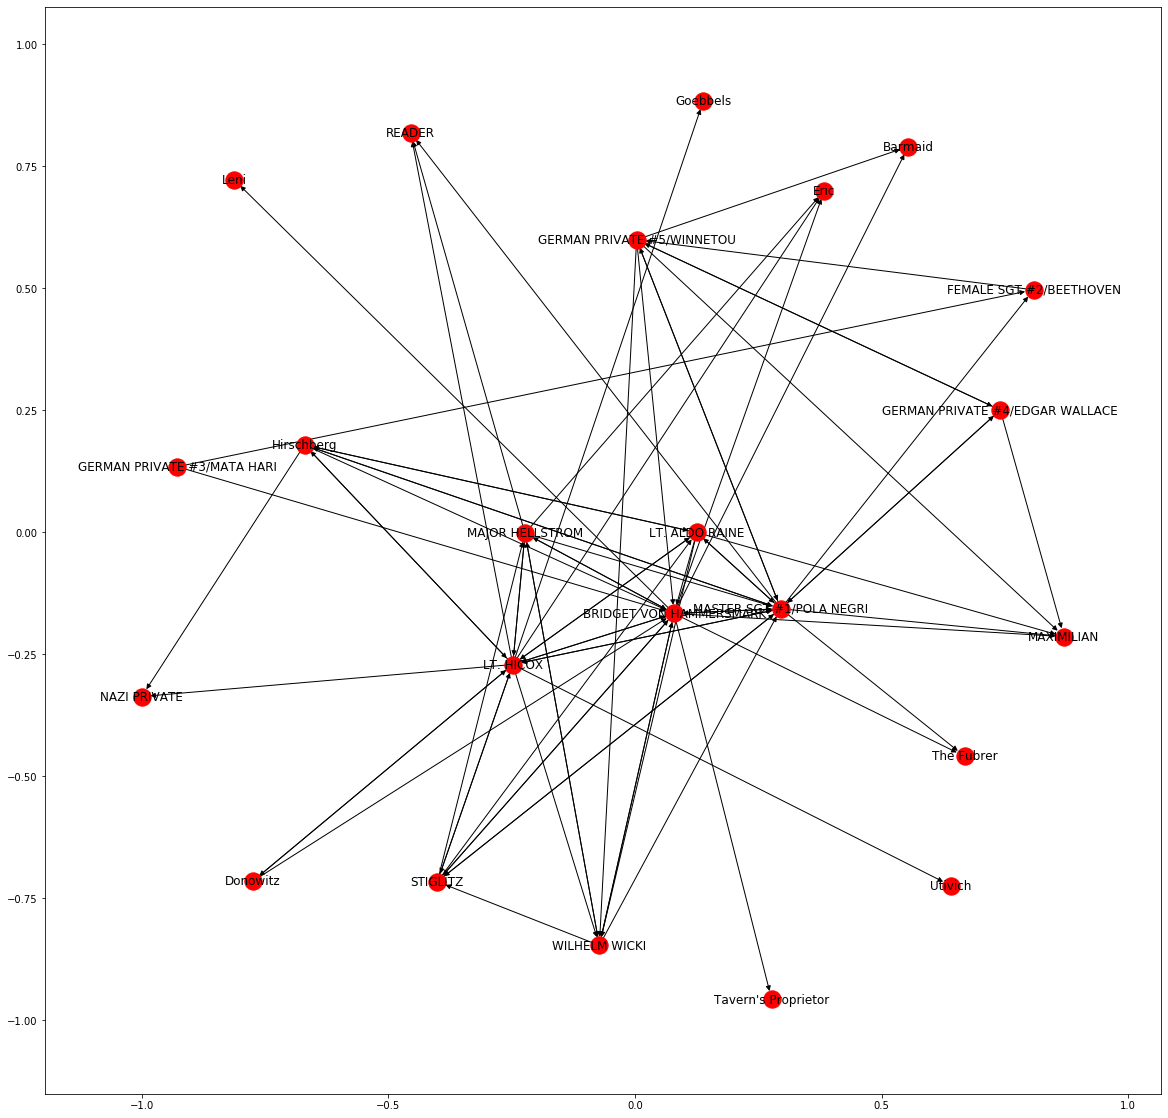

In [18]:
plt.figure(figsize=(20, 20))
nx.draw_networkx(D, pos=nx.spring_layout(D, k=2))

In [20]:
def create_graphs(speech_df, mention_df):
    characters = speech_df.columns
    speech_graph = nx.Graph()
    mention_graph = nx.DiGraph()
    
    for A in characters:
        for B in characters:
            if A != B:
                speech = speech_df.loc[A, B] + speech_df.loc[B, A]
                mention = mention_df.loc[A, B]
                if speech > 0:
                    speech_graph.add_edge(A, B, weight = speech)
                if mention > 0:
                    mention_graph.add_edge(A, B, weight = mention)
    
    return speech_graph, mention_graph

In [21]:
shawshank_speech_graph, shawshank_mention_graph = create_graphs(shawshank_speech_df, shawshank_mention_df)
basterds_speech_graph, basterds_mention_graph = create_graphs(basterds_speech_df, basterds_mention_df)
bourne_speech_graph, bourne_mention_graph = create_graphs(bourne_speech_df, bourne_mention_df)

In [22]:
basterds_speech_graph

In [29]:
sorted(basterds_speech_graph.degree(weight="weight"), key = lambda t: t[1], reverse = True)

[('LT. HICOX', 70.0),
 ('MASTER SGT #1/POLA NEGRI', 63.0),
 ('LT. ALDO RAINE', 60.0),
 ('MAJOR HELLSTROM', 56.0),
 ('BRIDGET VON HAMMERSMARK', 45.0),
 ('STIGLITZ', 20.0),
 ('WILHELM WICKI', 17.0),
 ('Hirschberg', 10.0),
 ('GERMAN PRIVATE #5/WINNETOU', 10.0),
 ('GERMAN PRIVATE #3/MATA HARI', 8.0),
 ('GERMAN PRIVATE #4/EDGAR WALLACE', 7.0),
 ('Donowitz', 6.0),
 ('Eric', 2.0),
 ('FEMALE SGT #2/BEETHOVEN', 2.0)]

In [31]:
sorted(basterds_mention_graph.in_degree(weight="weight"), key = lambda t: t[1], reverse = True)

[('BRIDGET VON HAMMERSMARK', 55.0),
 ('MASTER SGT #1/POLA NEGRI', 39.0),
 ('LT. HICOX', 34.0),
 ('MAJOR HELLSTROM', 25.0),
 ('LT. ALDO RAINE', 15.0),
 ('STIGLITZ', 14.0),
 ('MAXIMILIAN', 11.0),
 ('WILHELM WICKI', 8.0),
 ('READER', 5.0),
 ('Eric', 4.0),
 ('Hirschberg', 4.0),
 ('GERMAN PRIVATE #5/WINNETOU', 4.0),
 ('Donowitz', 3.0),
 ('Barmaid', 3.0),
 ('NAZI PRIVATE', 2.0),
 ('FEMALE SGT #2/BEETHOVEN', 2.0),
 ('GERMAN PRIVATE #4/EDGAR WALLACE', 2.0),
 ('The Fubrer', 2.0),
 ('Utivich', 1.0),
 ('Goebbels', 1.0),
 ('Leni', 1.0),
 ("Tavern's Proprietor", 1.0),
 ('GERMAN PRIVATE #3/MATA HARI', 0)]

In [41]:
S = nx.subgraph(basterds_speech_graph, ['LT. HICOX','MASTER SGT #1/POLA NEGRI','LT. ALDO RAINE','MAJOR HELLSTROM','BRIDGET VON HAMMERSMARK'])
H = nx.subgraph(basterds_mention_graph, ['LT. HICOX','MASTER SGT #1/POLA NEGRI','LT. ALDO RAINE','MAJOR HELLSTROM','BRIDGET VON HAMMERSMARK'])

In [39]:
sorted(S.degree(weight="weight"), key = lambda t: t[1], reverse = True)

[('LT. ALDO RAINE', 52.0),
 ('MASTER SGT #1/POLA NEGRI', 52.0),
 ('LT. HICOX', 50.0),
 ('MAJOR HELLSTROM', 44.0),
 ('BRIDGET VON HAMMERSMARK', 36.0)]

In [42]:
sorted(H.in_degree(weight="weight"), key = lambda t: t[1], reverse = True)

[('BRIDGET VON HAMMERSMARK', 46.0),
 ('MASTER SGT #1/POLA NEGRI', 34.0),
 ('LT. HICOX', 28.0),
 ('MAJOR HELLSTROM', 19.0),
 ('LT. ALDO RAINE', 12.0)]

/home/sbaruah/.pyenv/versions/3.6.7/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/sbaruah/.pyenv/versions/3.6.7/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


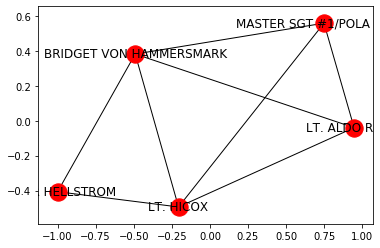

In [45]:
nx.draw_networkx(S)

In [52]:
for edge in S.edges:
    print(edge, S.edges[edge[0], edge[1]])

('LT. HICOX', 'LT. ALDO RAINE') {'weight': 10.0}
('LT. HICOX', 'MAJOR HELLSTROM') {'weight': 28.0}
('LT. HICOX', 'BRIDGET VON HAMMERSMARK') {'weight': 10.0}
('LT. HICOX', 'MASTER SGT #1/POLA NEGRI') {'weight': 2.0}
('MAJOR HELLSTROM', 'BRIDGET VON HAMMERSMARK') {'weight': 16.0}
('LT. ALDO RAINE', 'BRIDGET VON HAMMERSMARK') {'weight': 1.0}
('LT. ALDO RAINE', 'MASTER SGT #1/POLA NEGRI') {'weight': 41.0}
('MASTER SGT #1/POLA NEGRI', 'BRIDGET VON HAMMERSMARK') {'weight': 9.0}


/home/sbaruah/.pyenv/versions/3.6.7/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


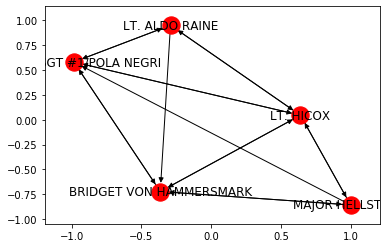

In [46]:
nx.draw_networkx(H)

In [53]:
for edge in H.edges:
    print(edge, H.edges[edge[0], edge[1]])

('LT. HICOX', 'LT. ALDO RAINE') {'weight': 3.0}
('LT. HICOX', 'MAJOR HELLSTROM') {'weight': 12.0}
('LT. HICOX', 'BRIDGET VON HAMMERSMARK') {'weight': 12.0}
('LT. HICOX', 'MASTER SGT #1/POLA NEGRI') {'weight': 3.0}
('MAJOR HELLSTROM', 'LT. HICOX') {'weight': 15.0}
('MAJOR HELLSTROM', 'BRIDGET VON HAMMERSMARK') {'weight': 7.0}
('MAJOR HELLSTROM', 'MASTER SGT #1/POLA NEGRI') {'weight': 2.0}
('LT. ALDO RAINE', 'LT. HICOX') {'weight': 4.0}
('LT. ALDO RAINE', 'BRIDGET VON HAMMERSMARK') {'weight': 10.0}
('LT. ALDO RAINE', 'MASTER SGT #1/POLA NEGRI') {'weight': 21.0}
('MASTER SGT #1/POLA NEGRI', 'LT. HICOX') {'weight': 2.0}
('MASTER SGT #1/POLA NEGRI', 'LT. ALDO RAINE') {'weight': 9.0}
('MASTER SGT #1/POLA NEGRI', 'BRIDGET VON HAMMERSMARK') {'weight': 17.0}
('BRIDGET VON HAMMERSMARK', 'LT. HICOX') {'weight': 7.0}
('BRIDGET VON HAMMERSMARK', 'MAJOR HELLSTROM') {'weight': 7.0}
('BRIDGET VON HAMMERSMARK', 'MASTER SGT #1/POLA NEGRI') {'weight': 8.0}


In [57]:
bourne_speech_df.columns

Index(['Wombosi', 'LEAD CRI AGENT', 'WILLS', 'BACK ROOM TECH', 'ROOF_AGENT',
       'TECH_SUPPORT', 'Conklin', 'AGENT 4', 'Daniels',
       'PARALLEL_SEDAN_DRIVER', 'CRI agent', 'Bourne', 'CRI AGENT', 'CRONIN',
       'Tac Team Leader', 'CRI_agent_CRASH_SITE', 'passenger side agent',
       'CRI_agent', 'TECH #4', 'Kramer', 'HOODED FIGURE', 'guard', 'READER',
       'security guard', 'TECH #3', 'Pamela Landy', 'Abbott', 'Vosen', 'Paz',
       'TECH #1', 'AGENT 3', 'NYPD officer', 'cop', 'TECH #2', 'HIRSCH',
       'PARKING GUY', 'Spotter', 'driver'],
      dtype='object')